# Predicting Insurance Premium
- 의료보험 데이터를 활용해서 보험료를 예측하는 회귀문제

## 데이터 이해
- charges: 보험료, 종속변수
- age: 나이
- gender: 성별
- bmi: body mass index, 체질량 지수
- children: 자녀 수
- smoker: 흡연 여부
- region: 거주 지역
- medical_history: 질병 이력
- family_medical_history: 가족 질병 이력
- exercise_frequency: 운동 빈도
- occupation: 직업 종류
- coverage_level: 보험 종류


In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
from datetime import datetime

# preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer

# validation
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_val_score

# valuation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# modeling
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# etc 
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 불러오기
data = pd.read_csv("C:/Users/sssum/Downloads/insurance_dataset.csv/insurance_dataset.csv")
data.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
0,46,male,21.45,5,yes,southeast,Diabetes,None,Never,Blue collar,Premium,20460.307669
1,25,female,25.38,2,yes,northwest,Diabetes,High blood pressure,Occasionally,White collar,Premium,20390.899218
2,38,male,44.88,2,yes,southwest,None,High blood pressure,Occasionally,Blue collar,Premium,20204.476302
3,25,male,19.89,0,no,northwest,None,Diabetes,Rarely,White collar,Standard,11789.029843
4,49,male,38.21,3,yes,northwest,Diabetes,High blood pressure,Rarely,White collar,Standard,19268.309838


In [3]:
# 데이터 기본 정보 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   age                     1000000 non-null  int64  
 1   gender                  1000000 non-null  object 
 2   bmi                     1000000 non-null  float64
 3   children                1000000 non-null  int64  
 4   smoker                  1000000 non-null  object 
 5   region                  1000000 non-null  object 
 6   medical_history         1000000 non-null  object 
 7   family_medical_history  1000000 non-null  object 
 8   exercise_frequency      1000000 non-null  object 
 9   occupation              1000000 non-null  object 
 10  coverage_level          1000000 non-null  object 
 11  charges                 1000000 non-null  float64
dtypes: float64(2), int64(2), object(8)
memory usage: 91.6+ MB


In [4]:
# 데이터 통계정보 확인
data.describe()

,age,bmi,children,charges
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,41.495282,34.001839,2.499886,16735.117481
std,13.855189,9.231680,1.707679,4415.808211
min,18.000000,18.000000,0.000000,3445.011643
25%,29.000000,26.020000,1.000000,13600.372379
50%,41.000000,34.000000,2.000000,16622.127973
75%,53.000000,41.990000,4.000000,19781.465410
max,65.000000,50.000000,5.000000,32561.560374


- 평균과 표준편차가 거의 비슷한 컬럼은 분포가 퍼져있을 확률이 높으므로 후에 분포를 모아주는 작업이 필요할 수 있음
- 값 범위가 크게 다른 속성이 있으면 스케일링 작업이 필요함, 종속변수는 제외

## EDA

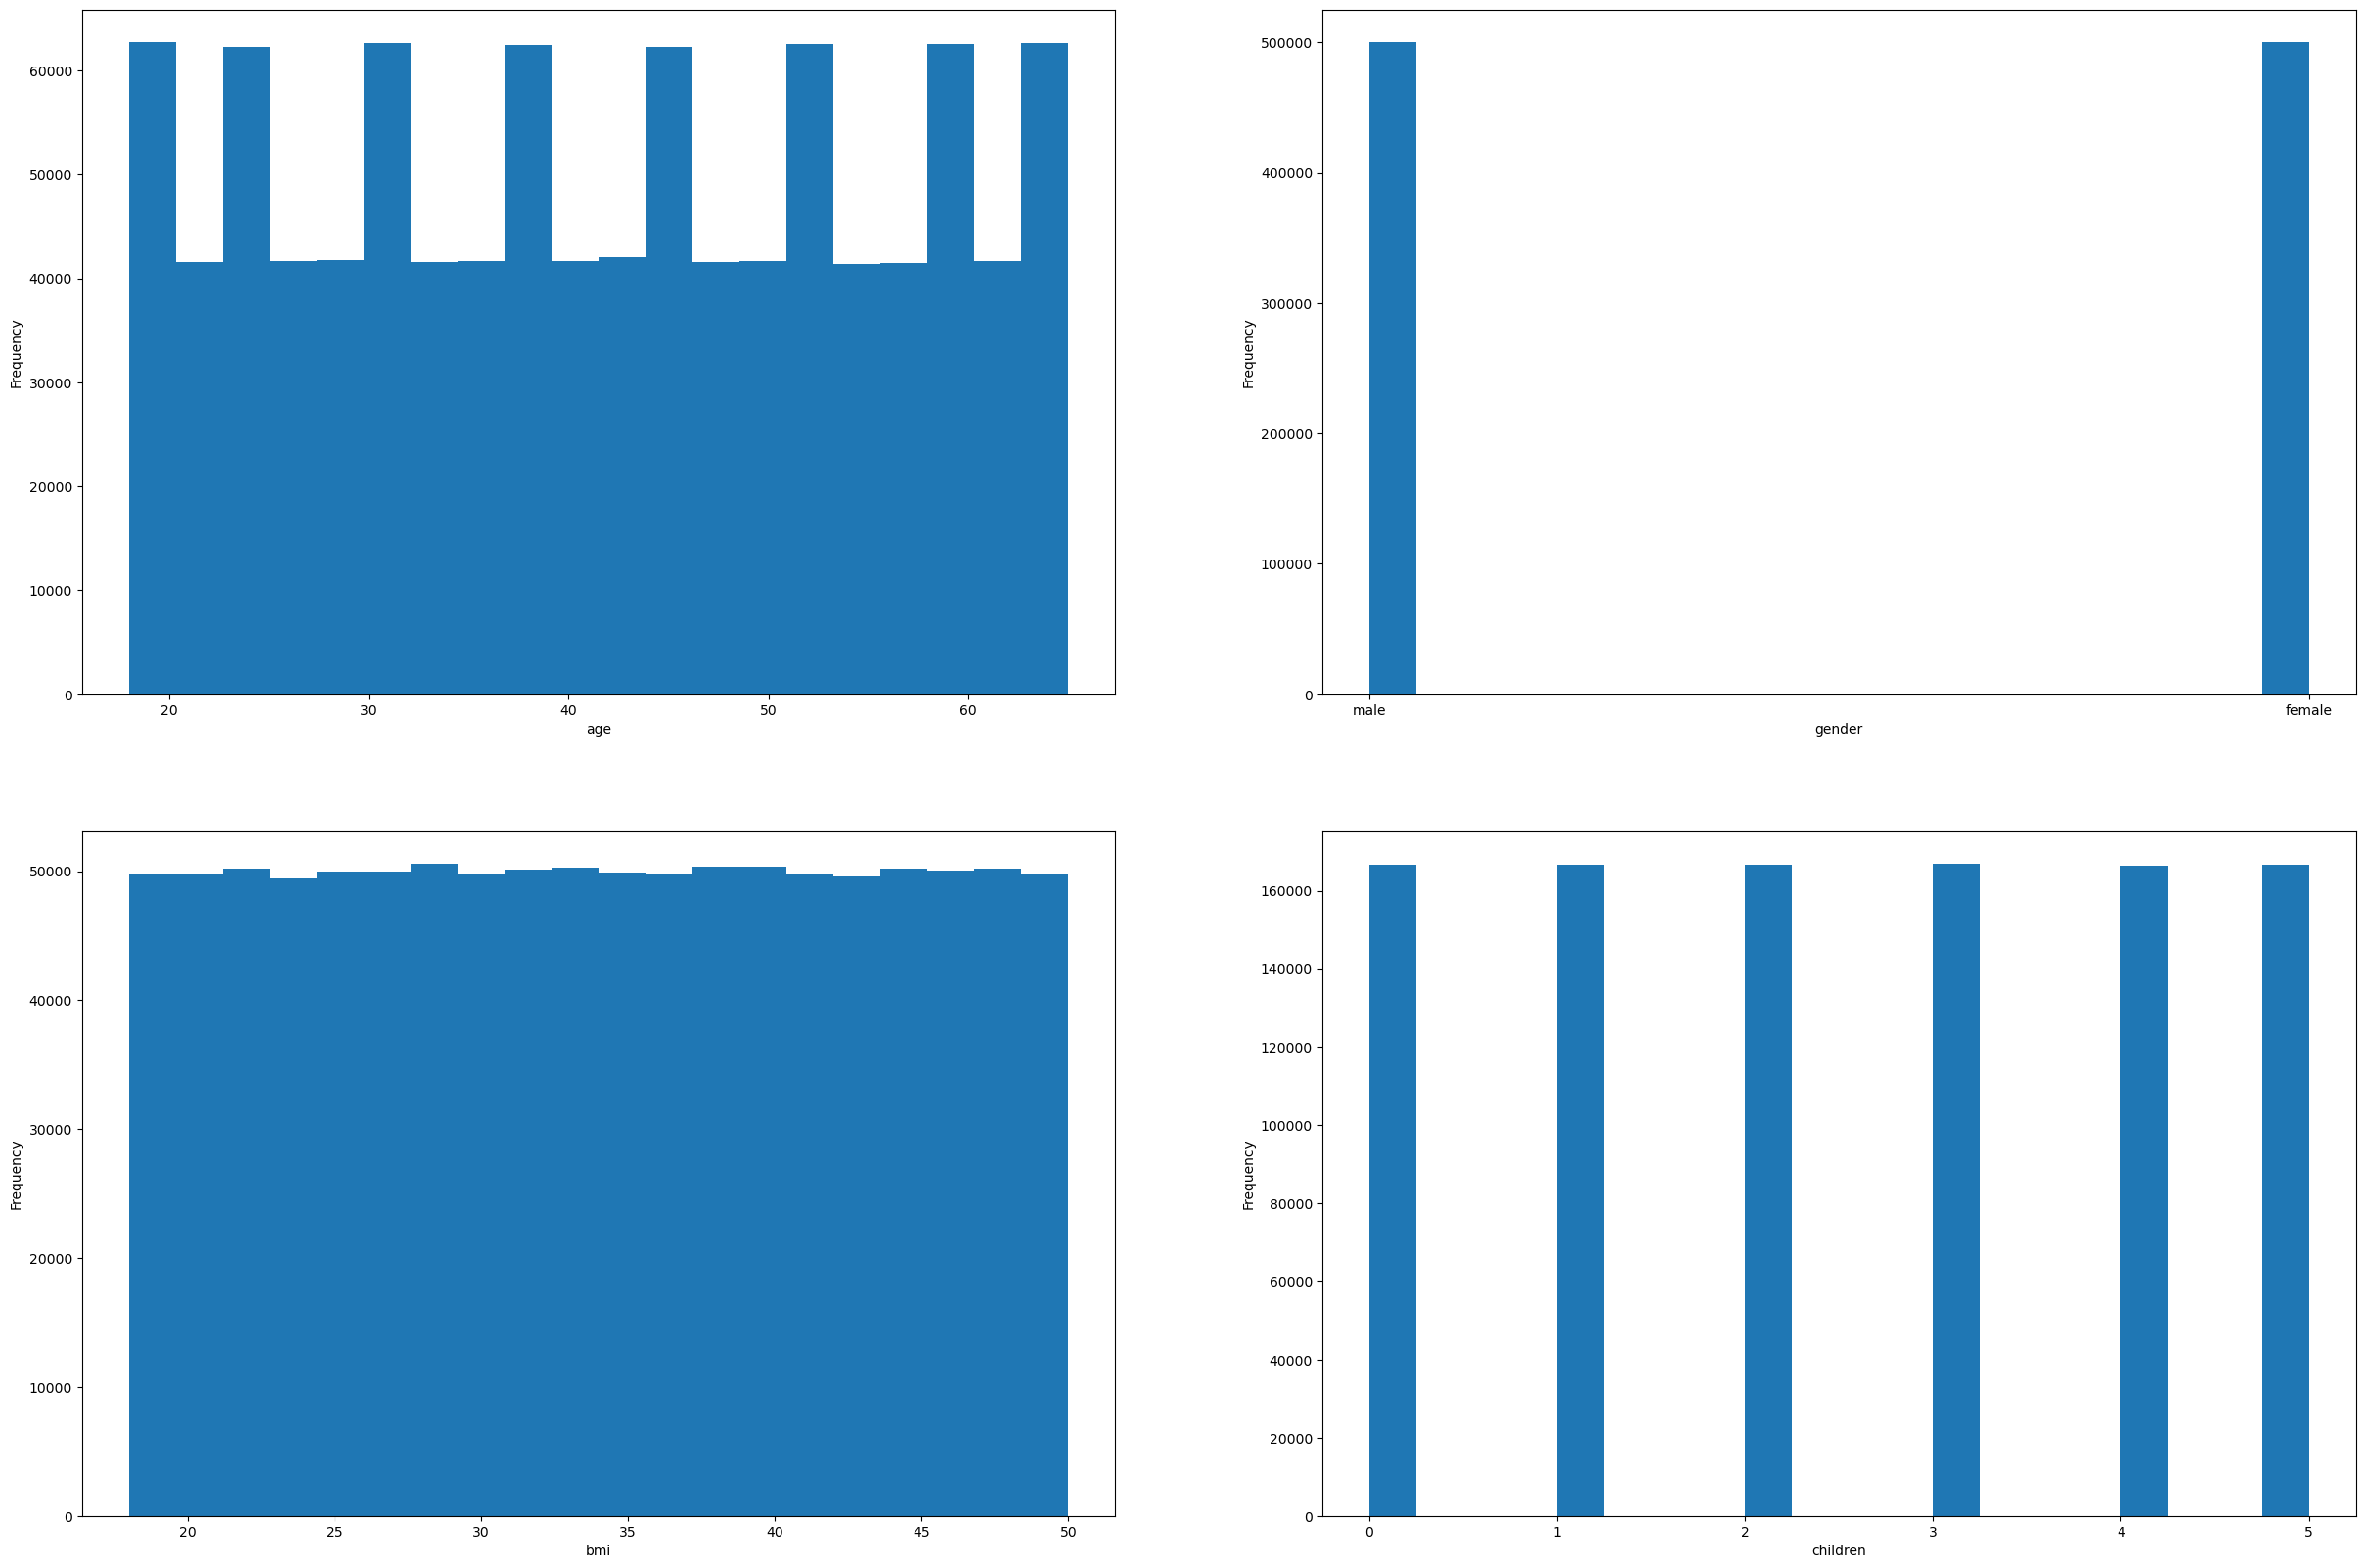

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(30, 20))

idx = 0
for i in range(2): # subplot 행
    for j in range(2): # subplot 열
        colname = list(data.columns)[idx]
        ax[i][j].hist(data[colname], bins=20)
        ax[i][j].set_xlabel(colname)
        ax[i][j].set_ylabel('Frequency')
        
        idx += 1

수치형 컬럼들의 값 분포를 보았을 때, 크게 치우친 부분 없이 고르게 분포되어 있음을 알 수 있음.

In [6]:
# 컬럼 간 상관관계 파악
data.corr()

,age,bmi,children,charges
age,1.000000,0.001428,-0.001317,0.063390
bmi,0.001428,1.000000,-0.001635,0.104429
children,-0.001317,-0.001635,1.000000,0.076801
charges,0.063390,0.104429,0.076801,1.000000


array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='bmi', ylabel='age'>,
        <Axes: xlabel='children', ylabel='age'>,
        <Axes: xlabel='charges', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='bmi'>,
        <Axes: xlabel='bmi', ylabel='bmi'>,
        <Axes: xlabel='children', ylabel='bmi'>,
        <Axes: xlabel='charges', ylabel='bmi'>],
       [<Axes: xlabel='age', ylabel='children'>,
        <Axes: xlabel='bmi', ylabel='children'>,
        <Axes: xlabel='children', ylabel='children'>,
        <Axes: xlabel='charges', ylabel='children'>],
       [<Axes: xlabel='age', ylabel='charges'>,
        <Axes: xlabel='bmi', ylabel='charges'>,
        <Axes: xlabel='children', ylabel='charges'>,
        <Axes: xlabel='charges', ylabel='charges'>]], dtype=object)

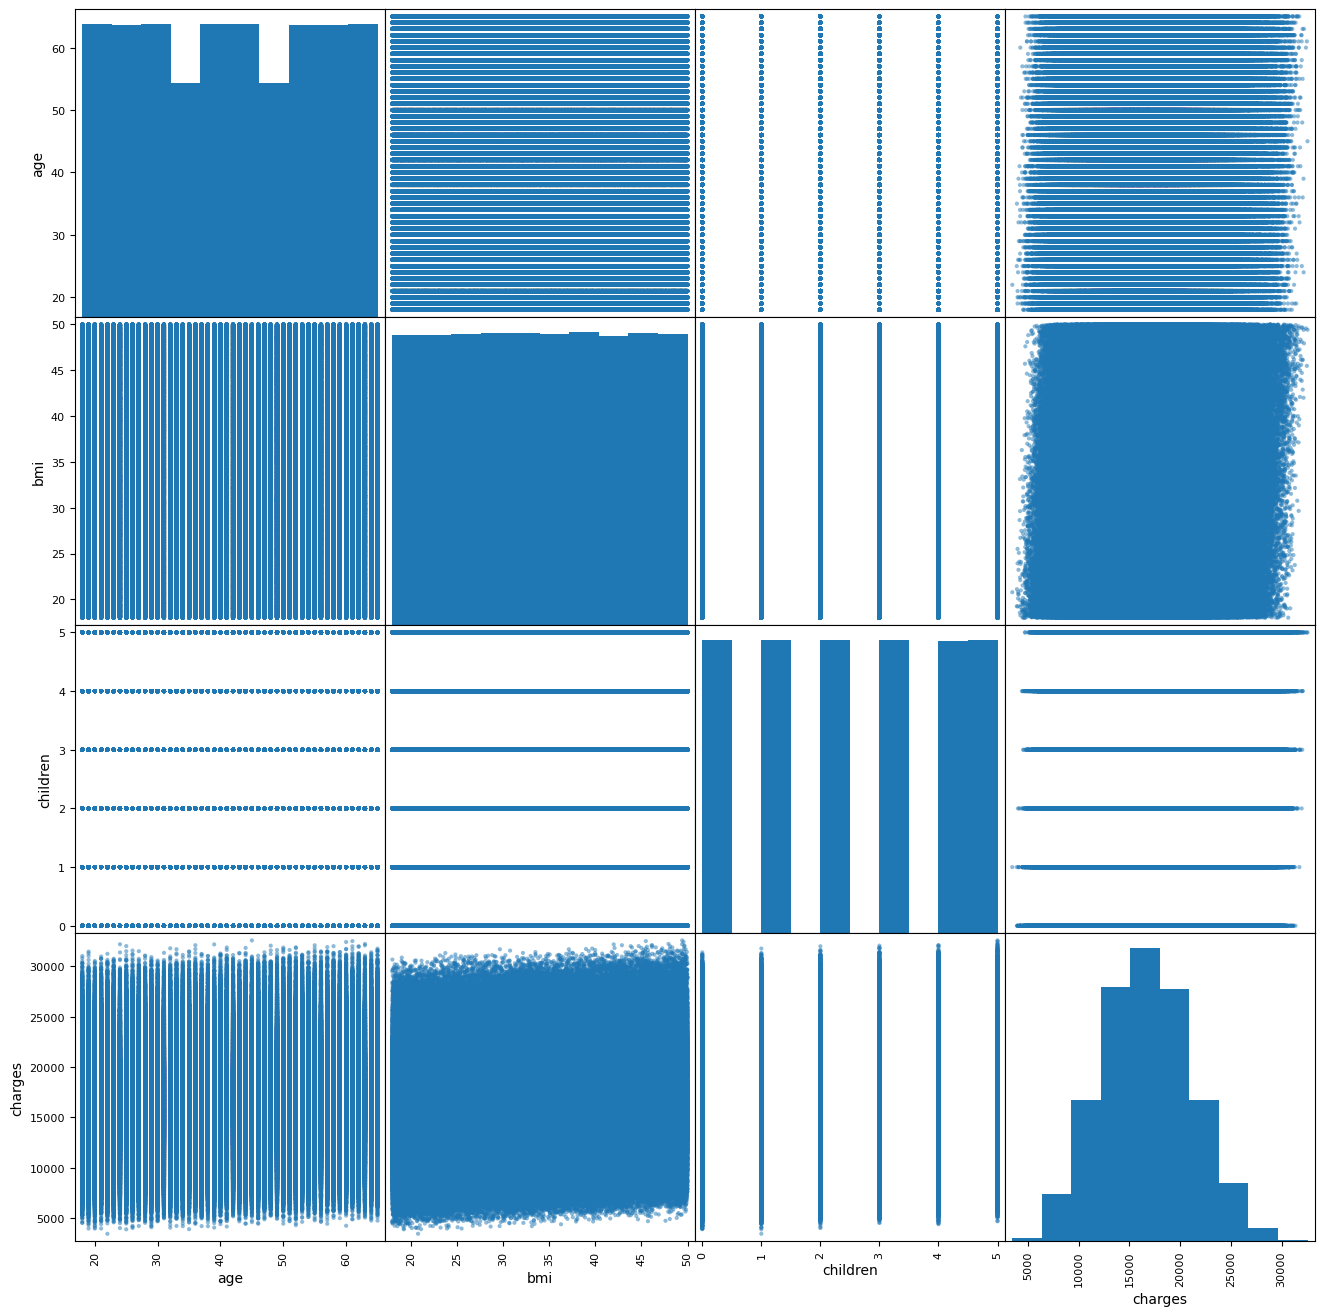

In [7]:
# 상관관계 시각화
pd.plotting.scatter_matrix(data, figsize=(16, 16))

상관관계가 높은 컬럼은 없음.

<Axes: ylabel='bmi'>

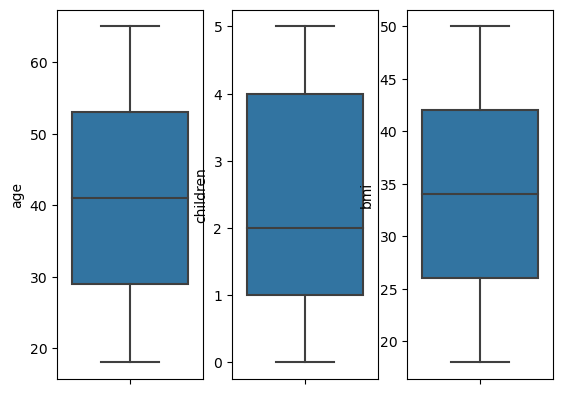

In [8]:
# 이상치 탐지
plt.subplot(1, 3, 1)
sns.boxplot(data=data, y='age')
plt.subplot(1, 3, 2)
sns.boxplot(data=data, y='children')
plt.subplot(1, 3, 3)
sns.boxplot(data=data, y='bmi')

이상치도 없음.

In [9]:
# 해당 문제는 이상치가 없지만, 이상치를 확인하는 방법 코드
bmi_q1 = data['bmi'].quantile(q=0.25)
bmi_q3 = data['bmi'].quantile(q=0.75)
iqr = bmi_q3 - bmi_q1

condi1 = (data['bmi'] < (bmi_q1 - (1.5 * iqr)))
condi2 = (data['bmi'] > (bmi_q3 + (1.5 * iqr)))
outliers = data[condi1 | condi2]
outliers['bmi']

Series([], Name: bmi, dtype: float64)

## 데이터 전처리
- 정규화: 변수 범위를 0~1 사이로 옮기는 작업, MinMaxScaler
- 표준화: 변수 범위 평균 0, 표준편차 1로 변환, StandardScaler

정규변환 (정규분포에 가깝게 변수를 변환)
- 로그변환: 변수에 로그를 취해주면 정규분포의 형태와 가깝게 변환됨
- Power Transformation: 특정 수식에 따른 변수 변환
- Quantile Transformation: 미리 정한 분포에 따라 그에 상승하는 x값 반환

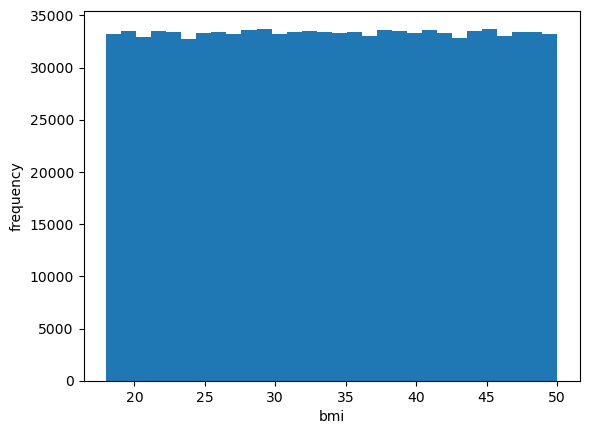

In [10]:
# 정규분포 확인
plt.figsize = (10, 10)
plt.hist(data['bmi'], bins=30)
plt.xlabel('bmi')
plt.ylabel('frequency')
plt.show()

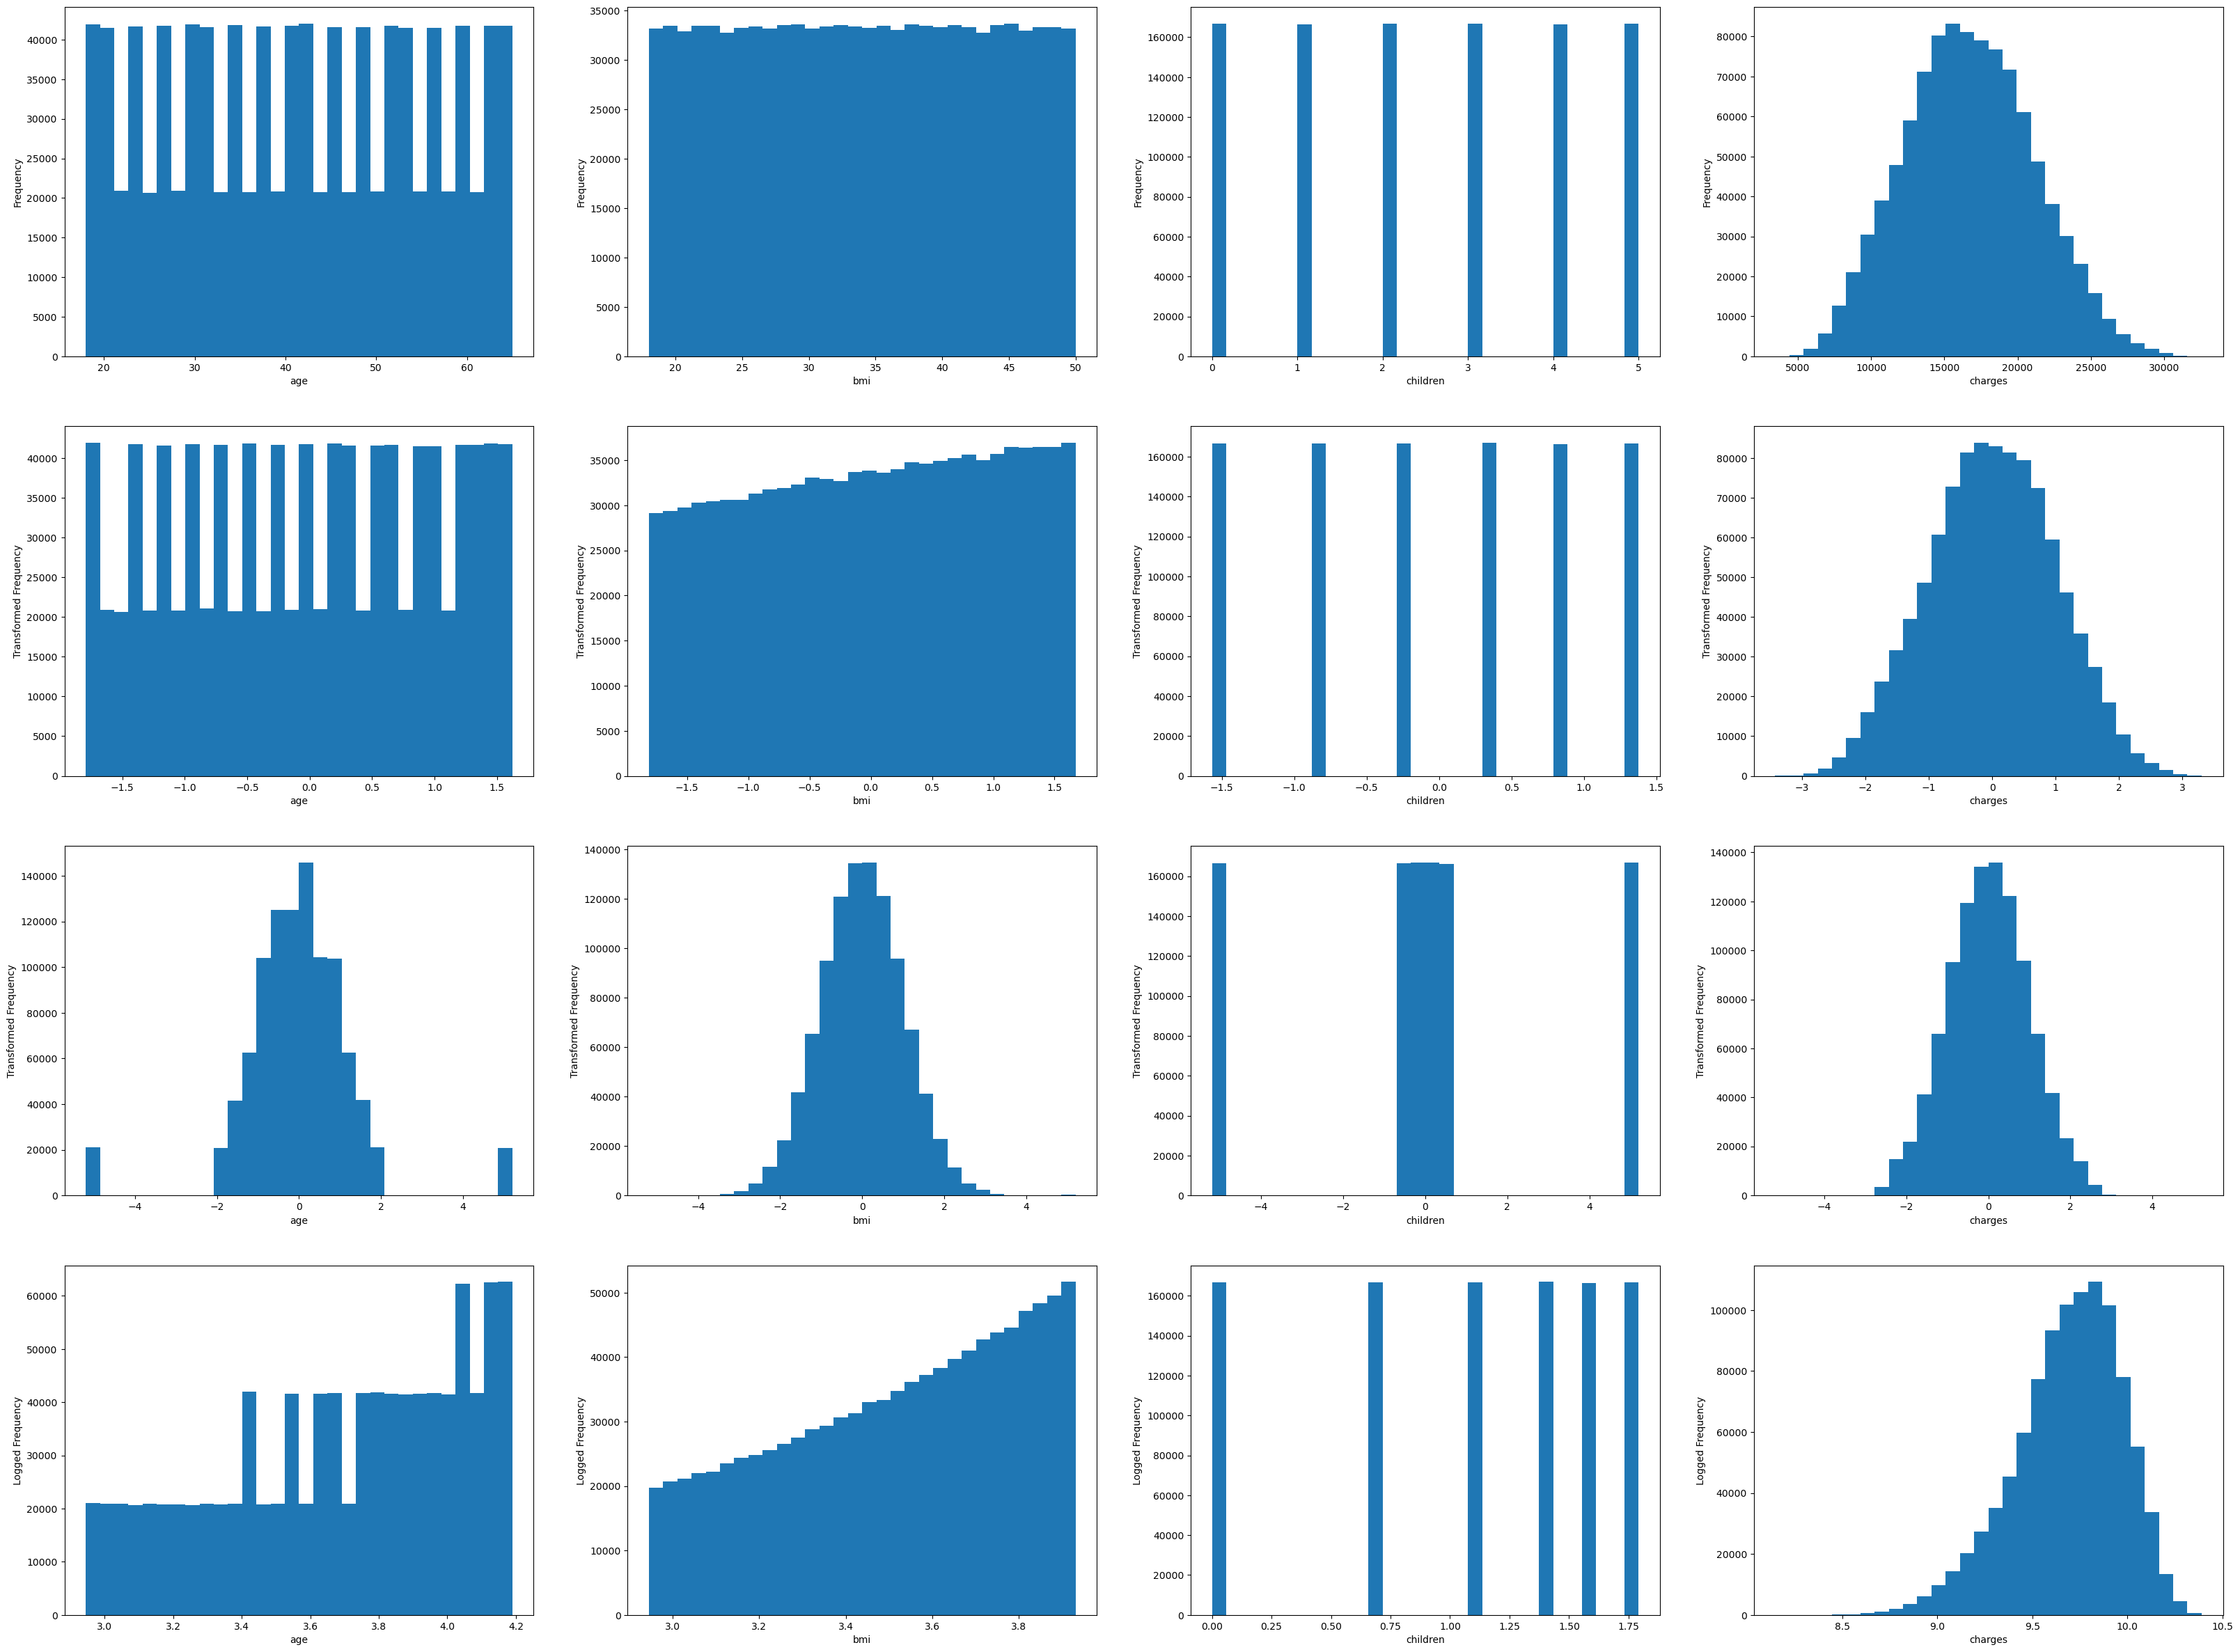

In [11]:
# 로그 변환
to_scale = ['age', 'bmi', 'children', 'charges']
df_to_scale = data[to_scale].copy()

quantile = QuantileTransformer(n_quantiles=100, random_state=42, output_distribution='normal')
power = PowerTransformer(method='yeo-johnson')
q_scaled = quantile.fit_transform(df_to_scale)
yj = power.fit_transform(df_to_scale)

q_scaled_df = pd.DataFrame(q_scaled, columns=to_scale)
scaled_df = pd.DataFrame(yj, columns=to_scale)
logged_df = pd.DataFrame(np.log1p(df_to_scale), columns=to_scale)
# 로그 특성상 0보다 작은 값이 있는 속성에는 사용 불가

fig, ax = plt.subplots(4, 4, figsize=(40, 30))

for i in range(4):
    idx=0
    for j in range(4):
        colname = to_scale[idx]
        if i == 0:
            ax[i][j].hist(df_to_scale[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Frequency')
            
        elif i == 1:
            ax[i][j].hist(scaled_df[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Transformed Frequency')  
        elif i == 2:
            ax[i][j].hist(q_scaled_df[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Transformed Frequency')
        elif i == 3:
            ax[i][j].hist(logged_df[colname], bins=30)
            ax[i][j].set_xlabel(colname)
            ax[i][j].set_ylabel('Logged Frequency')
            
        idx +=1

In [12]:
# 데이터 분할
x = data.drop(['charges'], axis=1)
y = data['charges']

train_input, test_input, train_target, test_target = train_test_split(x, y, test_size=0.5, shuffle=True)

In [13]:
# Quantile Transformer 사용
to_scale = ['age', 'bmi']

quantile = QuantileTransformer(n_quantiles=10, random_state=42, output_distribution='normal')

for col in to_scale:
    quantile.fit(train_input[[col]]) # 2차원 데이터로 투입하기 위해 괄호 두 개 사용
    train_input[col] = quantile.transform(train_input[[col]]).flatten()
    test_input[col] = quantile.transform(test_input[[col]]).flatten()

In [14]:
# 결과 확인
print(train_input.head())
print('-----------------')
print(test_input.head())

             age  gender       bmi  children smoker     region  \
612671 -0.703922  female  0.072634         3     no  northwest   
158857  0.139710  female -0.521135         0    yes  northwest   
321071 -0.430727  female  0.104140         1    yes  southeast   
991629  0.764710    male  0.229921         4     no  southeast   
264648 -0.841621  female  0.958665         5    yes  southeast   

            medical_history family_medical_history exercise_frequency  \
612671                 None               Diabetes              Never   
158857                 None               Diabetes         Frequently   
321071        Heart disease               Diabetes       Occasionally   
991629  High blood pressure    High blood pressure             Rarely   
264648  High blood pressure                   None              Never   

          occupation coverage_level  
612671  White collar          Basic  
158857       Student       Standard  
321071  White collar       Standard  
991629  Whit

In [15]:
# 표준화 진행
cols = ['age', 'bmi', 'children']
for col in cols:
    std = StandardScaler()
    std.fit(train_input[[col]])
    train_input[col] = std.transform(train_input[[col]]).flatten()
    test_input[col] = std.transform(test_input[[col]]).flatten()
    
train_input.describe()

,age,bmi,children
count,5.000000e+05,5.000000e+05,5.000000e+05
mean,6.642686e-18,-1.167422e-17,3.997513e-17
std,1.000001e+00,1.000001e+00,1.000001e+00
min,-3.743296e+00,-5.189515e+00,-1.462951e+00
25%,-5.017121e-01,-6.757071e-01,-8.775182e-01
50%,-1.420943e-02,-1.823392e-03,-2.920853e-01
75%,4.550598e-01,6.712204e-01,8.787804e-01
max,3.755049e+00,5.192918e+00,1.464213e+00


In [16]:
# 범주형 변수 처리 - gender
onehot_gender = OneHotEncoder()
gender_train = train_input[['gender']]
gender_test = test_input[['gender']]

onehot_gender.fit(gender_train)
gender_train_onehot_gender = onehot_gender.transform(gender_train).toarray()
gender_test_onehot_gender = onehot_gender.transform(gender_test).toarray()

train_input['gender'] = gender_train_onehot_gender[:, 1].astype(np.uint8)
test_input['gender'] = gender_test_onehot_gender[:, 1].astype(np.uint8)

train_input.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level
612671,-0.501712,0,0.074223,0.293348,no,northwest,None,Diabetes,Never,White collar,Basic
158857,0.106620,0,-0.518619,-1.462951,yes,northwest,None,Diabetes,Frequently,Student,Standard
321071,-0.304715,0,0.105679,-0.877518,yes,southeast,Heart disease,Diabetes,Occasionally,White collar,Standard
991629,0.557298,1,0.231263,0.878780,no,southeast,High blood pressure,High blood pressure,Rarely,White collar,Basic
264648,-0.601005,0,0.958869,1.464213,yes,southeast,High blood pressure,None,Never,Student,Premium


In [17]:
# 범주형 변수 처리 - smoker
onehot_smoker = OneHotEncoder()
smoker_train = train_input[['smoker']]
smoker_test = test_input[['smoker']]

onehot_smoker.fit(smoker_train)
smoker_train_onehot = onehot_smoker.transform(smoker_train).toarray()
smoker_test_onehot = onehot_smoker.transform(smoker_test).toarray()

train_input['smoker'] = smoker_train_onehot[:, 1].astype(np.uint8)
test_input['smoker'] = smoker_test_onehot[:, 1].astype(np.uint8)

train_input.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level
612671,-0.501712,0,0.074223,0.293348,0,northwest,None,Diabetes,Never,White collar,Basic
158857,0.106620,0,-0.518619,-1.462951,1,northwest,None,Diabetes,Frequently,Student,Standard
321071,-0.304715,0,0.105679,-0.877518,1,southeast,Heart disease,Diabetes,Occasionally,White collar,Standard
991629,0.557298,1,0.231263,0.878780,0,southeast,High blood pressure,High blood pressure,Rarely,White collar,Basic
264648,-0.601005,0,0.958869,1.464213,1,southeast,High blood pressure,None,Never,Student,Premium


In [18]:
# 먼저 라벨 인코더를 사용하여 거주지역을 숫자형으로 바꾸기
label_region = LabelEncoder()
label_region.fit(train_input['region'])

train_input['region'] = label_region.transform(train_input['region'])
test_input['region'] = label_region.transform(test_input['region'])

train_input.head()

,age,gender,bmi,children,smoker,region,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level
612671,-0.501712,0,0.074223,0.293348,0,1,None,Diabetes,Never,White collar,Basic
158857,0.106620,0,-0.518619,-1.462951,1,1,None,Diabetes,Frequently,Student,Standard
321071,-0.304715,0,0.105679,-0.877518,1,2,Heart disease,Diabetes,Occasionally,White collar,Standard
991629,0.557298,1,0.231263,0.878780,0,2,High blood pressure,High blood pressure,Rarely,White collar,Basic
264648,-0.601005,0,0.958869,1.464213,1,2,High blood pressure,None,Never,Student,Premium


In [19]:
# one-hot encoding으로 거주지역 바꾸기
onehot_region = OneHotEncoder()
region_train = train_input[['region']]
region_test = test_input[['region']]

onehot_region.fit(region_train)
region_train_onehot = onehot_region.transform(region_train).toarray()
region_test_onehot = onehot_region.transform(region_test).toarray()

train_input['region_1'] = region_train_onehot[:, 1].astype(np.uint8)
train_input['region_2'] = region_train_onehot[:, 2].astype(np.uint8)
train_input['region_3'] = region_train_onehot[:, 3].astype(np.uint8)


test_input['region_1'] = region_test_onehot[:, 1].astype(np.uint8)
test_input['region_2'] = region_test_onehot[:, 2].astype(np.uint8)
test_input['region_3'] = region_test_onehot[:, 3].astype(np.uint8)

train_input.drop(['region'], axis=1, inplace=True)
test_input.drop(['region'], axis=1, inplace=True)

In [20]:
# 결과 확인
train_input.head()

,age,gender,bmi,children,smoker,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,region_1,region_2,region_3
612671,-0.501712,0,0.074223,0.293348,0,None,Diabetes,Never,White collar,Basic,1,0,0
158857,0.106620,0,-0.518619,-1.462951,1,None,Diabetes,Frequently,Student,Standard,1,0,0
321071,-0.304715,0,0.105679,-0.877518,1,Heart disease,Diabetes,Occasionally,White collar,Standard,0,1,0
991629,0.557298,1,0.231263,0.878780,0,High blood pressure,High blood pressure,Rarely,White collar,Basic,0,1,0
264648,-0.601005,0,0.958869,1.464213,1,High blood pressure,None,Never,Student,Premium,0,1,0


In [21]:
# 그 외 범주형 변수 모두 변형
# medical_history
label_medical = LabelEncoder()
label_medical.fit(train_input['medical_history'])

train_input['medical_history'] = label_medical.transform(train_input['medical_history'])
test_input['medical_history'] = label_medical.transform(test_input['medical_history'])

train_input.head()

onehot_medical = OneHotEncoder()
medical_train = train_input[['medical_history']]
medical_test = test_input[['medical_history']]

onehot_medical.fit(medical_train)
medical_train_onehot = onehot_medical.transform(medical_train).toarray()
medical_test_onehot = onehot_medical.transform(medical_test).toarray()

train_input['medical_1'] = medical_train_onehot[:, 1].astype(np.uint8)
train_input['medical_2'] = medical_train_onehot[:, 2].astype(np.uint8)
train_input['medical_3'] = medical_train_onehot[:, 3].astype(np.uint8)


test_input['medical_1'] = medical_test_onehot[:, 1].astype(np.uint8)
test_input['medical_2'] = medical_test_onehot[:, 2].astype(np.uint8)
test_input['medical_3'] = medical_test_onehot[:, 3].astype(np.uint8)

train_input.drop(['medical_history'], axis=1, inplace=True)
test_input.drop(['medical_history'], axis=1, inplace=True)

In [22]:
# 그 외 범주형 변수 모두 변형
# family_medical_history
label_family = LabelEncoder()
label_family.fit(train_input['family_medical_history'])

train_input['family_medical_history'] = label_family.transform(train_input['family_medical_history'])
test_input['family_medical_history'] = label_family.transform(test_input['family_medical_history'])

train_input.head()

onehot_family = OneHotEncoder()
family_train = train_input[['family_medical_history']]
family_test = test_input[['family_medical_history']]

onehot_family.fit(family_train)
family_train_onehot = onehot_family.transform(family_train).toarray()
family_test_onehot = onehot_family.transform(family_test).toarray()

train_input['family_1'] = family_train_onehot[:, 1].astype(np.uint8)
train_input['family_2'] = family_train_onehot[:, 2].astype(np.uint8)
train_input['family_3'] = family_train_onehot[:, 3].astype(np.uint8)


test_input['family_1'] = family_test_onehot[:, 1].astype(np.uint8)
test_input['family_2'] = family_test_onehot[:, 2].astype(np.uint8)
test_input['family_3'] = family_test_onehot[:, 3].astype(np.uint8)

train_input.drop(['family_medical_history'], axis=1, inplace=True)
test_input.drop(['family_medical_history'], axis=1, inplace=True)

In [23]:
# 그 외 범주형 변수 모두 변형
# exercise_frequency
label_exercise = LabelEncoder()
label_exercise.fit(train_input['exercise_frequency'])

train_input['exercise_frequency'] = label_exercise.transform(train_input['exercise_frequency'])
test_input['exercise_frequency'] = label_exercise.transform(test_input['exercise_frequency'])

train_input.head()

onehot_exercise = OneHotEncoder()
exercise_train = train_input[['exercise_frequency']]
exercise_test = test_input[['exercise_frequency']]

onehot_exercise.fit(exercise_train)
exercise_train_onehot = onehot_exercise.transform(exercise_train).toarray()
exercise_test_onehot = onehot_exercise.transform(exercise_test).toarray()

train_input['exercise_1'] = exercise_train_onehot[:, 1].astype(np.uint8)
train_input['exercise_2'] = exercise_train_onehot[:, 2].astype(np.uint8)
train_input['exercise_3'] = exercise_train_onehot[:, 3].astype(np.uint8)


test_input['exercise_1'] = exercise_test_onehot[:, 1].astype(np.uint8)
test_input['exercise_2'] = exercise_test_onehot[:, 2].astype(np.uint8)
test_input['exercise_3'] = exercise_test_onehot[:, 3].astype(np.uint8)

train_input.drop(['exercise_frequency'], axis=1, inplace=True)
test_input.drop(['exercise_frequency'], axis=1, inplace=True)

In [24]:
train_input.head()

,age,gender,bmi,children,smoker,occupation,coverage_level,region_1,region_2,region_3,medical_1,medical_2,medical_3,family_1,family_2,family_3,exercise_1,exercise_2,exercise_3
612671,-0.501712,0,0.074223,0.293348,0,White collar,Basic,1,0,0,0,0,1,0,0,0,1,0,0
158857,0.106620,0,-0.518619,-1.462951,1,Student,Standard,1,0,0,0,0,1,0,0,0,0,0,0
321071,-0.304715,0,0.105679,-0.877518,1,White collar,Standard,0,1,0,1,0,0,0,0,0,0,1,0
991629,0.557298,1,0.231263,0.878780,0,White collar,Basic,0,1,0,0,1,0,0,1,0,0,0,1
264648,-0.601005,0,0.958869,1.464213,1,Student,Premium,0,1,0,0,1,0,0,0,1,1,0,0


In [25]:
# 그 외 범주형 변수 모두 변형
# occupation
label_occupation = LabelEncoder()
label_occupation.fit(train_input['occupation'])

train_input['occupation'] = label_occupation.transform(train_input['occupation'])
test_input['occupation'] = label_occupation.transform(test_input['occupation'])

train_input.head()

onehot_occupation = OneHotEncoder()
occupation_train = train_input[['occupation']]
occupation_test = test_input[['occupation']]

onehot_occupation.fit(occupation_train)
occupation_train_onehot = onehot_occupation.transform(occupation_train).toarray()
occupation_test_onehot = onehot_occupation.transform(occupation_test).toarray()

train_input['occupation_1'] = occupation_train_onehot[:, 1].astype(np.uint8)
train_input['occupation_2'] = occupation_train_onehot[:, 2].astype(np.uint8)
train_input['occupation_3'] = occupation_train_onehot[:, 3].astype(np.uint8)


test_input['occupation_1'] = occupation_test_onehot[:, 1].astype(np.uint8)
test_input['occupation_2'] = occupation_test_onehot[:, 2].astype(np.uint8)
test_input['occupation_3'] = occupation_test_onehot[:, 3].astype(np.uint8)

train_input.drop(['occupation'], axis=1, inplace=True)
test_input.drop(['occupation'], axis=1, inplace=True)

In [28]:
# 그 외 범주형 변수 모두 변형
# coverage_level
label_level = LabelEncoder()
label_level.fit(train_input['coverage_level'])

train_input['coverage_level'] = label_level.transform(train_input['coverage_level'])
test_input['coverage_level'] = label_level.transform(test_input['coverage_level'])

train_input.head()

onehot_level = OneHotEncoder()
level_train = train_input[['coverage_level']]
level_test = test_input[['coverage_level']]

onehot_level.fit(level_train)
level_train_onehot = onehot_level.transform(level_train).toarray()
level_test_onehot = onehot_level.transform(level_test).toarray()

train_input['level_1'] = level_train_onehot[:, 1].astype(np.uint8)
train_input['level_2'] = level_train_onehot[:, 2].astype(np.uint8)


test_input['level_1'] = level_test_onehot[:, 1].astype(np.uint8)
test_input['level_2'] = level_test_onehot[:, 2].astype(np.uint8)

train_input.drop(['coverage_level'], axis=1, inplace=True)
test_input.drop(['coverage_level'], axis=1, inplace=True)

In [29]:
# 결과 확인
train_input.head()

,age,gender,bmi,children,smoker,region_1,region_2,region_3,medical_1,medical_2,...,family_2,family_3,exercise_1,exercise_2,exercise_3,occupation_1,occupation_2,occupation_3,level_1,level_2
612671,-0.501712,0,0.074223,0.293348,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
158857,0.106620,0,-0.518619,-1.462951,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
321071,-0.304715,0,0.105679,-0.877518,1,0,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
991629,0.557298,1,0.231263,0.878780,0,0,1,0,0,1,...,1,0,0,0,1,0,0,1,0,0
264648,-0.601005,0,0.958869,1.464213,1,0,1,0,0,1,...,0,1,1,0,0,1,0,0,1,0


## 모델링
- linear model: Linear Regression, Elastic Net
- Decision Tree
- Ensemble: Random Forest, AdaBoost, Gradient Boosting
- Boosting: XGBoost, LightGBM, CatBoost 

In [30]:
# 데이터 확인
print(train_input.shape, train_target.shape)
print(test_input.shape, test_target.shape)

(500000, 22) (500000,)
(500000, 22) (500000,)


In [31]:
# 모델 객체 생성
lr = LinearRegression()
enet = ElasticNet(random_state=42)
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
ada = AdaBoostRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)
cat = CatBoostRegressor(silent=True, random_state=42)

models = [lr, enet, dt, rf, ada, gbr, xgb, lgbm, cat]

In [ ]:
for model in models:
    name = model.__class__.__name__
    scores = cross_val_score(model, X=train_input, y=train_target, cv=5,
                             scoring='neg_mean_squared_error', n_jobs=-1)
    mse = (-1) * np.mean(scores)
    print('Model %s - RMSE: %.4f' % (name, np.sqrt(mse)))

Model LinearRegression - RMSE: 336.7330
Model ElasticNet - RMSE: 3049.0233
Model DecisionTreeRegressor - RMSE: 614.0447
